In [1]:
import tensorflow as tf

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.2.0


In [5]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib # 比Os好用多了

In [6]:
import pathlib

In [7]:
# 二分类型的图，飞机、湖 --目录  比较小 比猫狗数据集
data_dir = 'datasets/2_class'

In [8]:
# 路径对象
data_root = pathlib.Path(data_dir)

In [9]:
data_root

WindowsPath('datasets/2_class')

In [10]:
# 对目录进行迭代,取出所有路径
for item in data_root.iterdir():
    print(item)

datasets\2_class\airplane
datasets\2_class\lake


In [11]:
# glob取得所有的数据
all_image_paths = list(data_root.glob('*/*'))

In [12]:
image_count = len(all_image_paths)

In [13]:
# 前三张图片
all_image_paths[:3]

[WindowsPath('datasets/2_class/airplane/airplane_001.jpg'),
 WindowsPath('datasets/2_class/airplane/airplane_002.jpg'),
 WindowsPath('datasets/2_class/airplane/airplane_003.jpg')]

In [14]:
# 后三张
all_image_paths[-3:]

[WindowsPath('datasets/2_class/lake/lake_698.jpg'),
 WindowsPath('datasets/2_class/lake/lake_699.jpg'),
 WindowsPath('datasets/2_class/lake/lake_700.jpg')]

In [15]:
import random
all_image_paths = [str(path) for path in all_image_paths]
# 乱序
random.shuffle(all_image_paths)
# 图片章数后面用于分类
image_count = len(all_image_paths)
image_count

1400

In [16]:
all_image_paths[:5]

['datasets\\2_class\\airplane\\airplane_215.jpg',
 'datasets\\2_class\\lake\\lake_241.jpg',
 'datasets\\2_class\\lake\\lake_052.jpg',
 'datasets\\2_class\\lake\\lake_227.jpg',
 'datasets\\2_class\\airplane\\airplane_012.jpg']

In [17]:
# data_root.glob('*/')提取所有目录 对其进行排序
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['airplane', 'lake']

In [18]:
# 转换成编码，此方法在多分类中庸的特比多
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'airplane': 0, 'lake': 1}

In [19]:
# 获取图片对应的label
pathlib.Path('dataset\\2_class\\lake\\lake_296.jpg').parent.name

'lake'

In [20]:
# 如39在使用index进行转换
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [21]:
all_image_labels[:5]

[0, 1, 1, 1, 0]

In [22]:
# 我们来查一下对应的图片 
all_image_paths[:5]

['datasets\\2_class\\airplane\\airplane_215.jpg',
 'datasets\\2_class\\lake\\lake_241.jpg',
 'datasets\\2_class\\lake\\lake_052.jpg',
 'datasets\\2_class\\lake\\lake_227.jpg',
 'datasets\\2_class\\airplane\\airplane_012.jpg']

In [23]:
import IPython.display as display # 绘图工具

In [24]:
# 得出其标签
index_to_label = dict((v,k) for k,v in label_to_index.items())
index_to_label

{0: 'airplane', 1: 'lake'}

In [25]:
def caption_image(label):
    return {0: 'airplane', 1: 'lake'}.get(label)

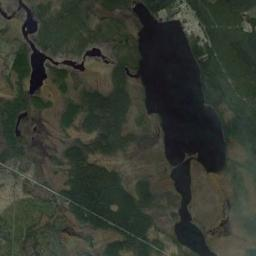

lake



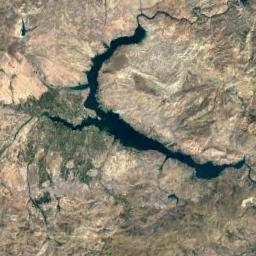

lake



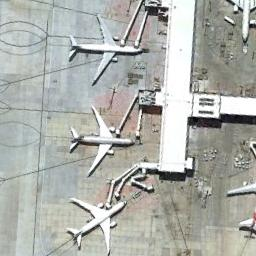

airplane



In [26]:
# 随机显示三个图片
for n in range(3):
    image_index = random.choice(range(len(all_image_paths)))
    display.display(display.Image(all_image_paths[image_index]))
    print(caption_image(all_image_labels[image_index]))
    print()

加载和格式化图像

In [27]:
img_path = all_image_paths[0]
img_path

'datasets\\2_class\\airplane\\airplane_215.jpg'

In [28]:
# 读取图片
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [29]:
# 解码图片
img_tensor = tf.image.decode_image(img_raw)
# 256 256 *3
print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 3)
<dtype: 'uint8'>


In [30]:
# 转换数据类型的方法.cast tf.float32
img_tensor = tf.cast(img_tensor, tf.float32)
# 标准化 归一化
img_final = img_tensor/255.0

print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(256, 256, 3)
0.0
0.92941177


In [31]:
# 把上面上个函数写成一个方法
def load_and_preprocess_image(path):
    # 读取路径
    image = tf.io.read_file(path)
    # 解码图片, 解析图片
    image = tf.image.decode_jpeg(image, channels=3)
    # 转换数据图片变形不影响判断告诉其图像大小是256
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

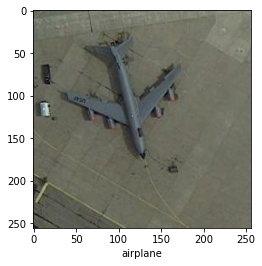

In [32]:
import matplotlib.pyplot as plt

# 取出的图片
image_path = all_image_paths[0]

label = all_image_labels[0]

# 加载并且预处理
plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(label))
print()

In [33]:
# 所有路径，建立了一个dataset
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [34]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [35]:
# 使用多线程对数据进行处理 tf.data.experimental.AUTOTUNE 根据可用的CPU动态设置并行调用的数量。
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [36]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [37]:
# 查看一下image_ds
image_ds

<ParallelMapDataset shapes: (256, 256, 3), types: tf.float32>

In [38]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

airplane
lake
lake
lake
airplane
airplane
airplane
airplane
lake
airplane


In [39]:
# 合并两个数据
image_label_ds = tf.data.Dataset.zip((image_ds,label_ds))

In [40]:
image_label_ds

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [41]:
# 划分测试数据和训练数据 百分之20 作为测试
test_count = int(image_count*0.2)
train_count = image_count - test_count

In [42]:
train_data = image_label_ds.skip(test_count)

test_data = image_label_ds.take(test_count)

In [43]:
# 每次训练32
BATCH_SIZE = 32

In [44]:

train_data = train_data.apply(
  # 此处增加设置dataset的repeat方法，可以是数据源源不断，范围是train_count
  tf.data.experimental.shuffle_and_repeat(buffer_size=train_count)
) 
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
train_data

# train_data = train_data.shuffle(buffer_size=train_count).batch(BATCH_SIZE)
# train_data

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [45]:
test_data = test_data.batch(BATCH_SIZE)

建立模型

In [46]:
model = tf.keras.Sequential()   #顺序模型
# 两层卷积,卷积核采用递增的格式 2的次方，64个卷积核大小为3，3
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
# 一层pool
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
# 二分类问题，最后输出应该为1，激活函数是simoid
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 256)       2

In [48]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [ ]:
# 整除， 需要训练多少个epoch
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [51]:
history = model.fit(train_data, epochs=6, steps_per_epoch=steps_per_epoch, validation_data=test_data, validation_steps=validation_steps)

Epoch 1/6
35/35 [==============================] - 622s 18s/step - loss: 0.1642 - acc: 0.9536 - val_loss: 0.3034 - val_acc: 0.9609
Epoch 2/6
35/35 [==============================] - 626s 18s/step - loss: 0.1441 - acc: 0.9598 - val_loss: 0.1750 - val_acc: 0.9609
Epoch 3/6
35/35 [==============================] - 648s 19s/step - loss: 0.1103 - acc: 0.9634 - val_loss: 0.2048 - val_acc: 0.9492
Epoch 4/6
35/35 [==============================] - 646s 18s/step - loss: 0.1085 - acc: 0.9634 - val_loss: 0.4656 - val_acc: 0.9492
Epoch 5/6
35/35 [==============================] - 636s 18s/step - loss: 0.1480 - acc: 0.9563 - val_loss: 0.3468 - val_acc: 0.9609
Epoch 6/6
35/35 [==============================] - 616s 18s/step - loss: 0.2883 - acc: 0.9321 - val_loss: 0.3613 - val_acc: 0.9297


In [52]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

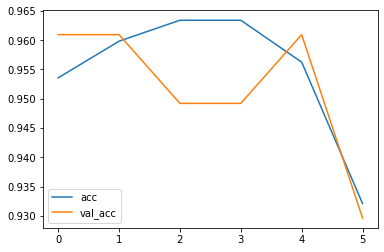

In [53]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

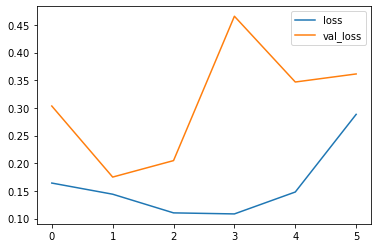

In [54]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

# 增加BN层

In [ ]:
model = tf.keras.Sequential()   #顺序模型
# 两层卷积,卷积核采用递增的格式 2的次方，64个卷积核大小为3，3
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# 一层pool
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# 二分类问题，最后输出应该为1，激活函数是simoid
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()